In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torch torchvision numpy matplotlib scikit-image tifffile
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms

import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import recall_score, precision_score, f1_score


In [13]:
class CarvanaDataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
            self.images = sorted([root_path+"/"+i for i in os.listdir(root_path+"/")])
            self.masks = sorted([root_path+"_masks/"+i for i in os.listdir(root_path+"_masks/")])
        else:
            self.images = sorted([root_path+"/train/"+i for i in os.listdir(root_path+"/train/")])
            self.masks = sorted([root_path+"/train_masks/"+i for i in os.listdir(root_path+"/train_masks/")])

        if len(self.images) != len(self.masks):
            raise ValueError(f"Mismatch between images and masks: {len(self.images)} images and {len(self.masks)} masks")

        print(f"Dataset contains {len(self.images)} images and {len(self.masks)} masks.")

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

In [6]:
"""
import time  # Importing the time module
import torch
from sklearn.metrics import f1_score

# Function to calculate IoU
def calculate_iou(pred, mask):
    pred = (pred > 0.5).float()  # Threshold predictions
    intersection = (pred * mask).sum().item()
    union = pred.sum().item() + mask.sum().item() - intersection
    return intersection / union if union != 0 else 0

# Function to calculate DSC/F1 Score
def calculate_dsc(pred, mask):
    pred = (pred > 0.5).float()  # Threshold predictions
    intersection = (pred * mask).sum().item()
    return (2 * intersection) / (pred.sum().item() + mask.sum().item()) if (pred.sum().item() + mask.sum().item()) != 0 else 0

# Function to calculate Pixel Accuracy
def calculate_pixel_accuracy(pred, mask):
    pred = (pred > 0.5).float()  # Threshold predictions
    correct_pixels = (pred == mask).sum().item()
    total_pixels = mask.numel()
    return correct_pixels / total_pixels

def train_one_epoch(model, train_dataloader, optimizer, criterion, device):
    model.train()
    train_running_loss = 0

    epoch_start_time = time.time()  # Start time of the epoch

    for idx, (img, mask) in enumerate(tqdm(train_dataloader, desc="Training Epoch")):
        step_start_time = time.time()  # Start time of each step

        img, mask = img.to(device), mask.to(device)

        optimizer.zero_grad()
        y_pred = model(img)

        loss = criterion(y_pred, mask)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

        step_end_time = time.time()  # End time of the step
        print(f"Step {idx + 1} took {step_end_time - step_start_time:.4f} seconds", end = "\r")

    epoch_end_time = time.time()  # End time of the epoch
    print(f"Train epoch took {epoch_end_time - epoch_start_time:.4f} seconds")

    return train_running_loss / (idx + 1)

def validate_one_epoch(model, val_dataloader, criterion, device):
    model.eval()
    val_running_loss = 0
    iou_total, dsc_total, pixel_accuracy_total = 0, 0, 0

    epoch_start_time = time.time()  # Start time of the epoch

    with torch.no_grad():
        for idx, (img, mask) in enumerate(tqdm(val_dataloader, desc="Validating Epoch")):
            step_start_time = time.time()  # Start time of each step

            img, mask = img.to(device), mask.to(device)
            y_pred = model(img)

            loss = criterion(y_pred, mask)
            val_running_loss += loss.item()

            # Compute metrics
            iou_total += calculate_iou(y_pred, mask)
            dsc_total += calculate_dsc(y_pred, mask)
            pixel_accuracy_total += calculate_pixel_accuracy(y_pred, mask)

            step_end_time = time.time()  # End time of the step
            print(f"Validation Step {idx + 1} took {step_end_time - step_start_time:.4f} seconds")

    epoch_end_time = time.time()  # End time of the epoch
    print(f"Validation epoch took {epoch_end_time - epoch_start_time:.4f} seconds")

    # Calculate average metrics
    avg_iou = iou_total / (idx + 1)
    avg_dsc = dsc_total / (idx + 1)
    avg_pixel_accuracy = pixel_accuracy_total / (idx + 1)

    print(f"Validation IoU: {avg_iou:.4f}, DSC (F1): {avg_dsc:.4f}, Pixel Accuracy: {avg_pixel_accuracy:.4f}")

    return val_running_loss / (idx + 1), avg_iou, avg_dsc, avg_pixel_accuracy

def main():
    LEARNING_RATE = 3e-4
    BATCH_SIZE = 8
    EPOCHS = 6
    DATA_PATH = "/content/drive/My Drive/BITSAuto/Assignment_3/data"
    MODEL_SAVE_PATH = "/content/drive/My Drive/BITSAuto/Assignment_3/models/unet.pth"

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Initialize dataset
    train_dataset = CarvanaDataset(DATA_PATH)

    # Split dataset
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

    # DataLoader setup
    train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

    # Model, optimizer, and loss function setup
    model = UNet(in_channels=3, num_classes=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    # Training loop
    for epoch in tqdm(range(EPOCHS)):
        epoch_start_time = time.time()  # Start time of the epoch

        # Train and validate for each epoch
        train_loss = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
        val_loss, avg_iou, avg_dsc, avg_pixel_accuracy = validate_one_epoch(model, val_dataloader, criterion, device)

        epoch_end_time = time.time()  # End time of the epoch
        print(f"Epoch {epoch + 1} total time: {epoch_end_time - epoch_start_time:.4f} seconds")

        print("-" * 30)
        print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print(f"Valid Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print(f"Validation Metrics - IoU: {avg_iou:.4f}, DSC (F1): {avg_dsc:.4f}, Pixel Accuracy: {avg_pixel_accuracy:.4f}")
        print("-" * 30)

    # Ensure the model save directory exists
    model_save_dir = os.path.dirname(MODEL_SAVE_PATH)
    os.makedirs(model_save_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")

if __name__ == "__main__":
    main()
"""

'\nimport time  # Importing the time module\nimport torch\nfrom sklearn.metrics import f1_score\n\n# Function to calculate IoU\ndef calculate_iou(pred, mask):\n    pred = (pred > 0.5).float()  # Threshold predictions\n    intersection = (pred * mask).sum().item()\n    union = pred.sum().item() + mask.sum().item() - intersection\n    return intersection / union if union != 0 else 0\n\n# Function to calculate DSC/F1 Score\ndef calculate_dsc(pred, mask):\n    pred = (pred > 0.5).float()  # Threshold predictions\n    intersection = (pred * mask).sum().item()\n    return (2 * intersection) / (pred.sum().item() + mask.sum().item()) if (pred.sum().item() + mask.sum().item()) != 0 else 0\n\n# Function to calculate Pixel Accuracy\ndef calculate_pixel_accuracy(pred, mask):\n    pred = (pred > 0.5).float()  # Threshold predictions\n    correct_pixels = (pred == mask).sum().item()\n    total_pixels = mask.numel()\n    return correct_pixels / total_pixels\n\ndef train_one_epoch(model, train_dataloa

<ipython-input-15-0f9dc873d85d>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


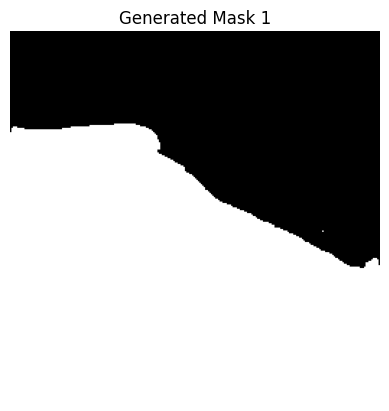

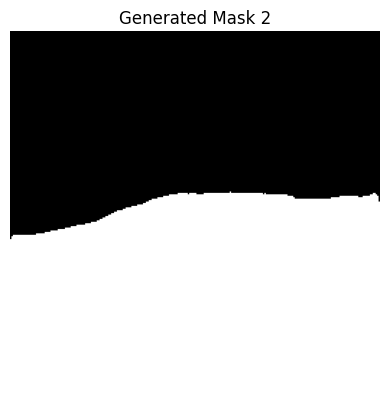

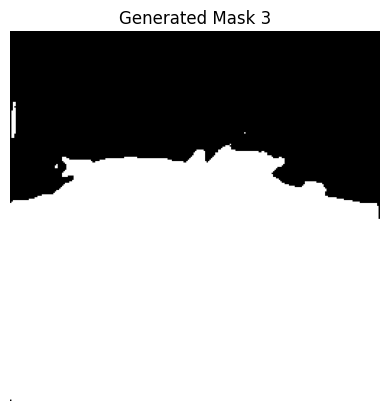

<ipython-input-15-0f9dc873d85d>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))


Dataset contains 3 images and 3 masks.


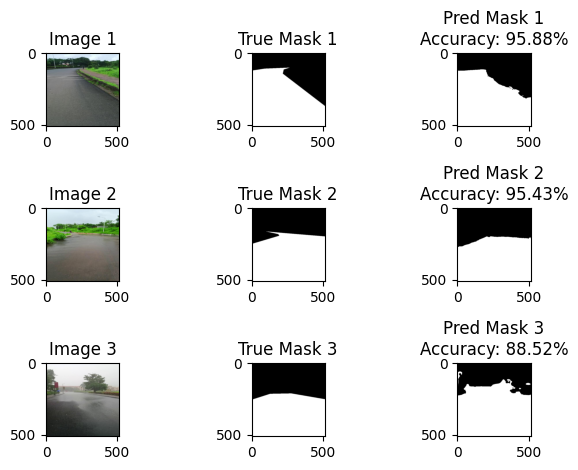

In [15]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Function to load the model weights
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set model to evaluation mode
    return model

# Function to make predictions and generate masks
def generate_masks(model, images, device):
    model.to(device)  # Move model to the correct device
    generated_masks = []

    with torch.no_grad():  # Disable gradient calculation during inference
        for img in images:
            img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device

            # Forward pass to get predictions
            y_pred = model(img)

            # Threshold predictions to create binary masks (e.g., using 0.5 as a threshold)
            predicted_masks = (y_pred > 0.5).float()

            generated_masks.append(predicted_masks.cpu())  # Move to CPU for further processing

    return generated_masks

# Example of how to visualize and save generated masks with original filenames
def save_and_visualize_masks(generated_masks, input_images, input_image_filenames, output_dir, save_images=False):
    os.makedirs(output_dir, exist_ok=True)

    for i, (mask, img_filename) in enumerate(zip(generated_masks, input_image_filenames)):
        mask = mask.squeeze().cpu().numpy()  # Remove batch and channel dimensions

        # Visualize the mask
        plt.imshow(mask, cmap='gray')
        plt.title(f"Generated Mask {i+1}")
        plt.axis('off')

        if save_images:
            # Generate mask filename based on original image filename
            mask_filename = os.path.splitext(img_filename)[0] + "_mask.png"
            mask_image = Image.fromarray((mask * 255).astype(np.uint8))  # Convert to 0-255 range
            mask_image.save(os.path.join(output_dir, mask_filename))

        plt.show()

# Function to compute pixel-wise accuracy
def compute_accuracy(pred_mask, orig_mask):
    pred_mask = pred_mask.squeeze().cpu().numpy()
    orig_mask = orig_mask.squeeze().cpu().numpy()

    # Flatten the masks and compute accuracy
    pred_mask_flat = pred_mask.flatten()
    orig_mask_flat = orig_mask.flatten()

    # Pixel-wise accuracy
    accuracy = np.sum(pred_mask_flat == orig_mask_flat) / orig_mask_flat.size

    return accuracy

# Function to display image grid with accuracy
def pred_show_image_grid(data_path, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))
    image_dataset = CarvanaDataset(data_path, test=True)
    images = []
    orig_masks = []
    pred_masks = []
    accuracies = []

    for img, orig_mask in image_dataset:
        img = img.float().to(device)
        img = img.unsqueeze(0)

        pred_mask = model(img)

        img = img.squeeze(0).cpu().detach()
        img = img.permute(1, 2, 0)

        pred_mask = pred_mask.squeeze(0).cpu().detach()
        pred_mask = pred_mask.permute(1, 2, 0)
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1

        orig_mask = orig_mask.cpu().detach()
        orig_mask = orig_mask.permute(1, 2, 0)

        # Calculate accuracy for this mask
        accuracy = compute_accuracy(pred_mask, orig_mask)
        accuracies.append(accuracy)

        images.append(img)
        orig_masks.append(orig_mask)
        pred_masks.append(pred_mask)

    images.extend(orig_masks)
    images.extend(pred_masks)
    fig = plt.figure()

    for i in range(len(image_dataset)):
        # Display original image
        fig.add_subplot(3, len(image_dataset), 3*i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"Image {i+1}")

        # Display original mask
        fig.add_subplot(3, len(image_dataset), 3*i + 2)
        plt.imshow(orig_masks[i], cmap="gray")
        plt.title(f"True Mask {i+1}")

        # Display predicted mask with accuracy
        fig.add_subplot(3, len(image_dataset), 3*i + 3)
        plt.imshow(pred_masks[i], cmap="gray")
        plt.title(f"Pred Mask {i+1}\nAccuracy: {accuracies[i]*100:.2f}%")

    plt.tight_layout()
    plt.show()

# Main function to run the prediction
def main():
    # Paths and settings
    MODEL_PATH = "/content/drive/My Drive/BITSAuto/Assignment_3/models/unet.pth"
    INPUT_IMAGE_DIR = "/content/drive/My Drive/BITSAuto/Assignment_3/data/manual_test"
    OUTPUT_DIR = "/content/drive/My Drive/BITSAuto/Assignment_3/data/generated_masks"

    # Example: Load input images and their filenames
    input_image_filenames = os.listdir(INPUT_IMAGE_DIR)
    input_images = [Image.open(os.path.join(INPUT_IMAGE_DIR, img_name)) for img_name in input_image_filenames]

    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize if necessary
        transforms.ToTensor(),          # Convert to tensor
    ])

    # Apply transformation to images
    input_images = [transform(img) for img in input_images]

    # Load the model and weights
    model = UNet(in_channels=3, num_classes=1)  # Define your model architecture
    model = load_model(model, MODEL_PATH)

    # Run inference to generate masks
    generated_masks = generate_masks(model, input_images, device='cuda' if torch.cuda.is_available() else 'cpu')

    # Save and visualize the generated masks
    save_and_visualize_masks(generated_masks, input_images, input_image_filenames, OUTPUT_DIR, save_images=True)
    pred_show_image_grid(INPUT_IMAGE_DIR, MODEL_PATH, device='cuda' if torch.cuda.is_available() else 'cpu')

if __name__ == "__main__":
    main()
